In [ ]:
!pip install medmnist

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from medmnist import INFO  # Contains dataset metadata
import medmnist          # This imports all available MedMNIST dataset classes

In [ ]:
breastmnist.npz

dermamnist.npz

octmnist.npz

organamnist.npz

organcmnist.npz

organsmnist.npz

pathmnist.npz

pneumoniamnist.npz

retinamnist.npz

tissuemnist.npz

In [5]:
from pprint import pprint

# Specify the dataset flag you want to use; here we use 'bloodmnist'
data_flag = 'bloodmnist'

# Get the info dictionary for the selected dataset
info = INFO[data_flag]
print("Dataset Info:")
pprint(info)
# Dynamically get the dataset class (e.g., BloodMNIST)
DataClass = getattr(medmnist, info['python_class'])


Dataset Info:
{'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c',
 'MD5_224': 'b718ff6835fcbdb22ba9eacccd7b2601',
 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b',
 'description': 'The BloodMNIST is based on a dataset of individual normal '
                'cells, captured from individuals without infection, '
                'hematologic or oncologic disease and free of any '
                'pharmacologic treatment at the moment of blood collection. It '
                'contains a total of 17,092 images and is organized into 8 '
                'classes. We split the source dataset with a ratio of 7:1:2 '
                'into training, validation and test set. The source images '
                'with resolution 3×360×363 pixels are center-cropped into '
                '3×200×200, and then resized into 3×28×28.',
 'label': {'0': 'basophil',
           '1': 'eosinophil',
           '2': 'erythroblast',
           '3': 'immature granulocytes(myel

In [7]:
data_flag = 'pathmnist'
download = True

# Retrieve dataset info and corresponding class from MedMNIST
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define the transformation pipeline for RGB images with size 28x28.
# The pipeline includes:
#  - Resizing the image to 28x28,
#  - Converting the image to a tensor,
#  - Normalizing with standard ImageNet values (commonly used for RGB images).
data_transform = transforms.Compose([  # Resize images to 28x28
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define batch size for the DataLoader
BATCH_SIZE = 64

# Load the training dataset.
# Note that we use size=28 to ensure the images are resized by the dataset loader,
# and mmap_mode='r' to enable memory mapping in read-only mode.
train_dataset = DataClass(
    split='train',
    transform=data_transform,
    download=download,
    size=28,          # Ensure images are 28x28
    mmap_mode='r'     # Use memory mapping for efficient reading
)

# Create the DataLoader to encapsulate the dataset into batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# (Optional) Iterate over one batch to verify the image shapes
for images, labels in train_loader:
    print("Images shape:", images.shape)  # Expected shape: [BATCH_SIZE, 3, 28, 28]
    print("Labels shape:", labels.shape)
    break


100%|██████████| 205615438/205615438 [08:33<00:00, 400063.47it/s] 


Images shape: torch.Size([64, 3, 28, 28])
Labels shape: torch.Size([64, 1])


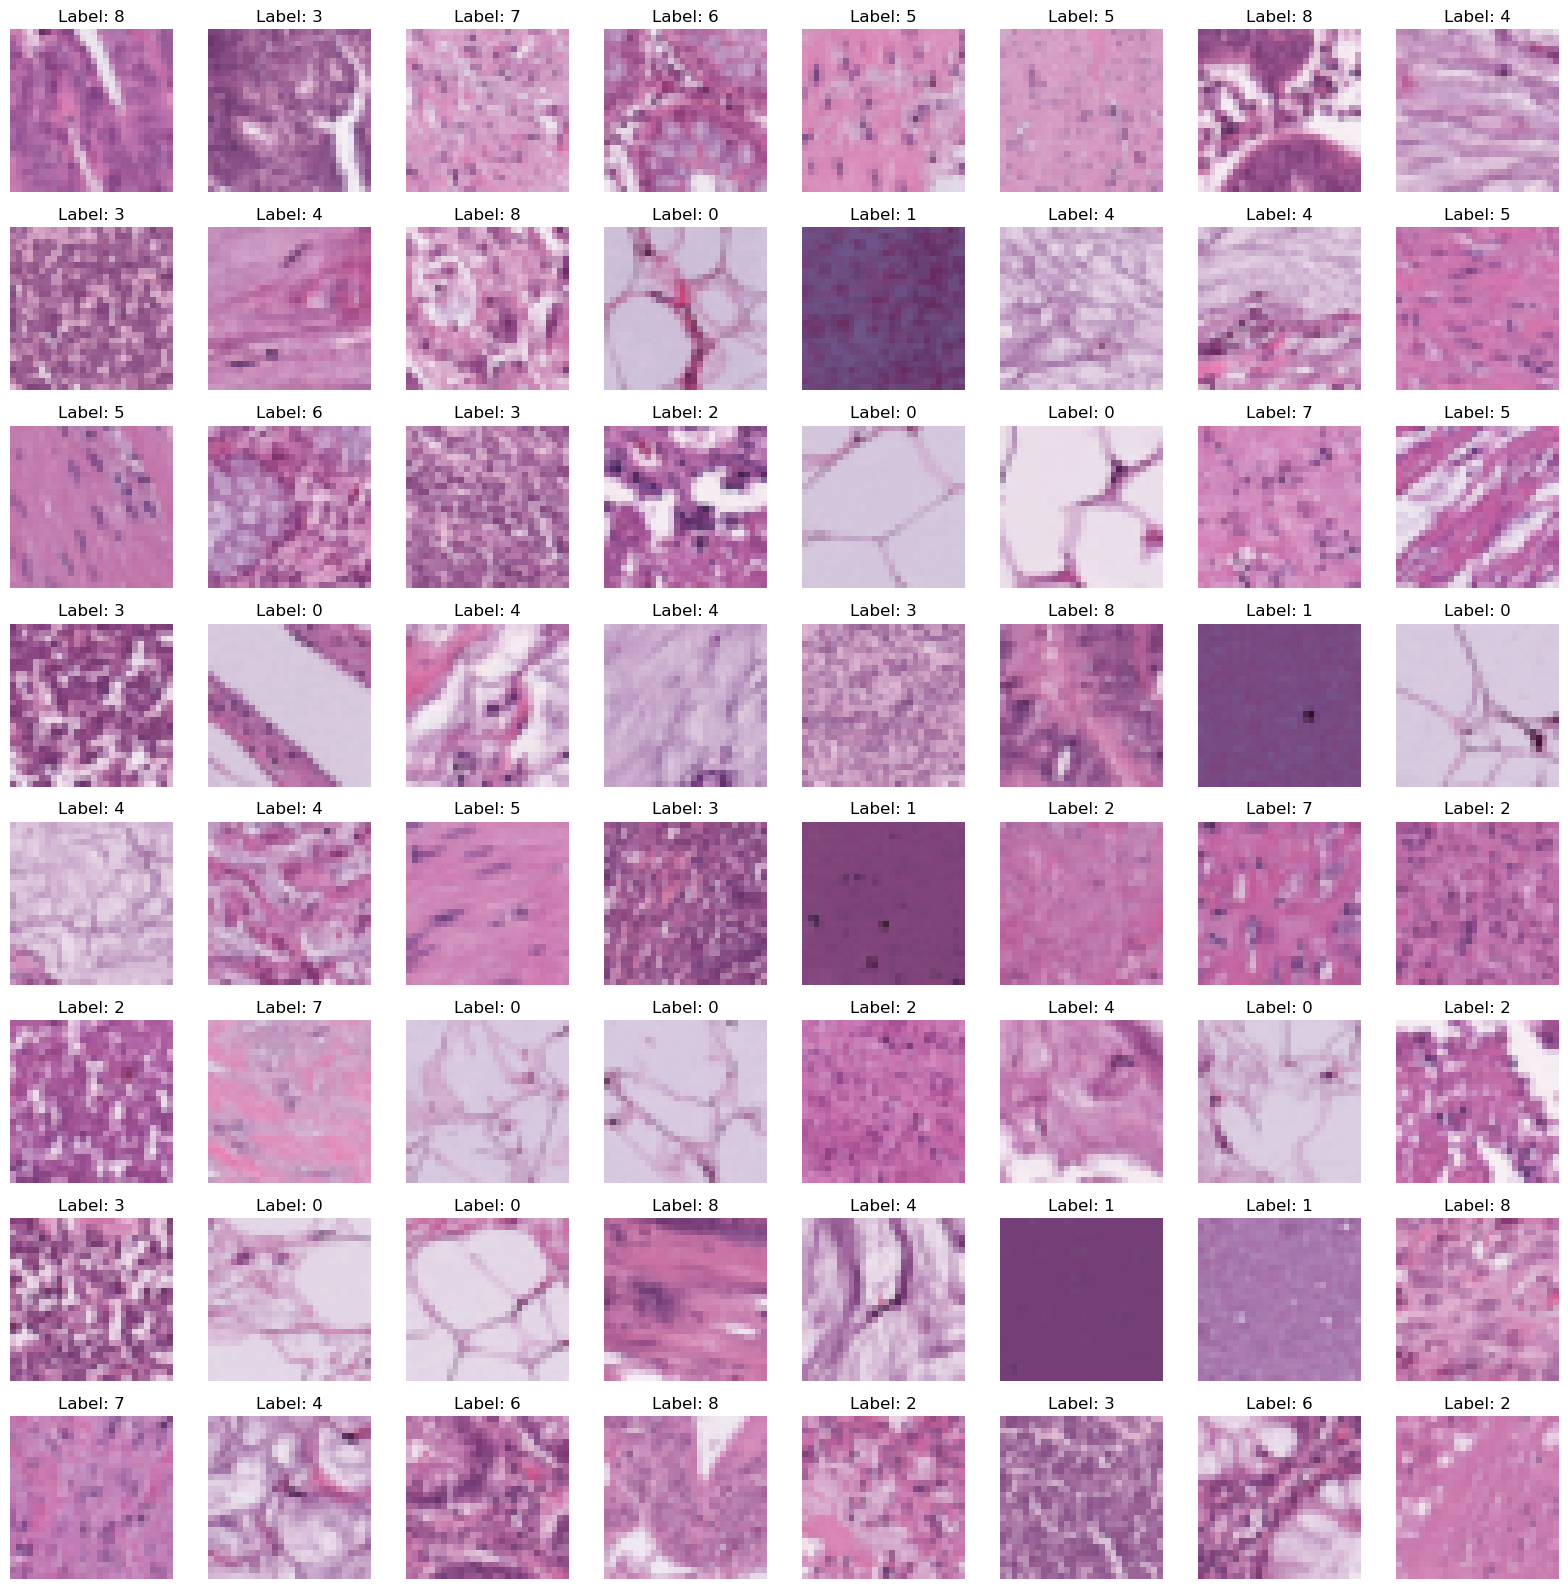

In [11]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))

# Define the mean and std for denormalization (same as used during normalization)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Determine grid size: for instance, 8 images per row
batch_size = images.shape[0]
ncols = 8
nrows = math.ceil(batch_size / ncols)

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
axs = axs.flatten()  # flatten in case of a multi-dimensional array of axes

# Denormalize and plot each image along with its label
for i in range(batch_size):
    # Convert the image tensor to a numpy array and transpose to (H, W, C)
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    # Denormalize the image: x_orig = x * std + mean
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

# Hide any remaining subplots if batch_size is not a perfect multiple of ncols
for j in range(batch_size, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Example architecture
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Because 28/2/2 = 7 (two pooling layers)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)            # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set number of classes according to your dataset
num_classes = len(info['label'])  # or you can hardcode if known, e.g., 9 or 10

# Initialize the model
model = SimpleCNN(num_classes=num_classes)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
import torch

# Number of epochs to train
num_epochs = 10

# Set the device: if on Mac M1 with MPS support, use it
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

# Move model to device
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Move data to the device.
        # Squeeze labels if needed to remove extra dimensions.
        images, labels = images.to(device), labels.squeeze().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete!")

Using MPS backend
Epoch [1/10], Loss: 0.7505
Epoch [2/10], Loss: 0.4499
Epoch [3/10], Loss: 0.3431
Epoch [4/10], Loss: 0.2787
Epoch [5/10], Loss: 0.2291
Epoch [6/10], Loss: 0.1927
Epoch [7/10], Loss: 0.1646
Epoch [8/10], Loss: 0.1406
Epoch [9/10], Loss: 0.1201
Epoch [10/10], Loss: 0.1023
Training complete!


In [15]:
# Specify the dataset flag (using PathMNIST as an example)
data_flag = 'pathmnist'
download = True

# Retrieve dataset info and corresponding class from MedMNIST
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define the transformation pipeline for RGB images
data_transform = transforms.Compose([  # Ensure images are resized to 28x28
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization values for RGB images
                         std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = DataClass(
    split='test',
    transform=data_transform,
    download=download,
    size=28,           # Ensure images are 28x28 (optional if already set in transforms)
    mmap_mode='r'      # Use memory mapping in read-only mode
)

# Wrap the test dataset in a DataLoader for batching and easy iteration
BATCH_SIZE = 64
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example: Verify the test data by printing one batch's shape
for images, labels in test_loader:
    print("Test images shape:", images.shape)  # Expected: [BATCH_SIZE, 3, 28, 28]
    print("Test labels shape:", labels.shape)    # Expected: [BATCH_SIZE, 1] or [BATCH_SIZE]
    break


Using downloaded and verified file: /Users/home/.medmnist/pathmnist.npz
Test images shape: torch.Size([64, 3, 28, 28])
Test labels shape: torch.Size([64, 1])


In [16]:
# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.squeeze().to(device)
        
        # Forward pass: compute outputs
        outputs = model(images)
        
        # Compute the loss for the current batch
        loss = criterion(outputs, labels.long())
        test_loss += loss.item() * images.size(0)  # Accumulate loss
        
        # Compute the predictions and count correct predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute the average loss and accuracy over the test dataset
avg_test_loss = test_loss / total
accuracy = correct / total * 100

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


Test Loss: 1.1061
Test Accuracy: 81.52%


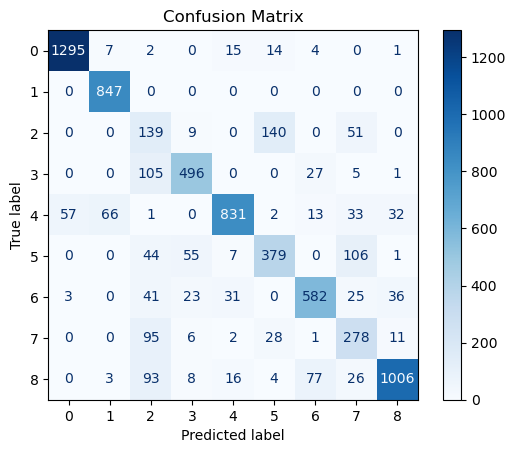

In [17]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode and collect predictions for the entire test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [18]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        print("Predictions:", preds)
        print("Ground Truth:", labels)
        break

Predictions: tensor([8, 4, 4, 8, 4, 4, 8, 0, 6, 8, 6, 6, 8, 6, 0, 2, 0, 5, 0, 5, 5, 0, 1, 8,
        8, 0, 1, 2, 6, 0, 0, 8, 0, 0, 1, 2, 5, 3, 7, 6, 5, 6, 7, 8, 0, 3, 6, 5,
        8, 7, 3, 1, 3, 3, 0, 1, 7, 0, 0, 0, 4, 4, 4, 0], device='mps:0')
Ground Truth: tensor([8, 4, 4, 8, 4, 4, 8, 0, 6, 8, 8, 6, 8, 6, 0, 5, 0, 2, 0, 5, 2, 0, 1, 8,
        8, 0, 1, 6, 6, 0, 0, 8, 0, 0, 1, 7, 5, 3, 4, 6, 5, 6, 4, 8, 0, 3, 6, 2,
        6, 7, 3, 1, 3, 3, 0, 1, 7, 0, 0, 0, 4, 4, 4, 0], device='mps:0')
